In [1]:
import os 
import time 
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cude' if torch.cuda.is_available() else 'cpu')
torch.use_deterministic_algorithms(True)

In [2]:
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname),
                               encoding='utf8') as f:
            review_list += [f.read()]
            label_list += [label]

print(f"Number of reviews : {len(review_list)}")

100%|███████████████████████████████████| 12500/12500 [00:01<00:00, 8941.77it/s]

Number of reviews : 25000


In [3]:
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review if letter not in punctuation])
               for review in tqdm(review_list)]
reviews_blob = ' '.join(review_list)
review_words = reviews_blob.split()
count_words = Counter(review_words)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)
print(sorted_review_words[:10])

100%|██████████████████████████████████| 25000/25000 [00:00<00:00, 38055.41it/s]

[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


In [4]:
vocab_to_token = {word: idx+1 for idx, (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


In [5]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print(reviews_tokenized[0])

for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem imagine a movie where joe piscopo is actually funny maureen stapleton is a scene stealer the moroni character is an absolute scream watch for alan the skipper hale jr as a police sgt

[15, 3, 17, 11, 201, 56, 1165, 47, 242, 23, 3, 168, 4, 891, 4325, 3513, 15, 10, 1514, 822, 3, 17, 112, 884, 14623, 6, 155, 161, 7307, 15816, 6, 3, 134, 20049, 1, 32064, 108, 6, 33, 1492, 1943, 103, 15, 1550, 1, 18993, 9055, 1809, 14, 3, 549, 6906]


In [6]:
encoded_label_list = [1 if label == 'pos' else 0 for label in label_list]
reviews_len = [len(review) for review in reviews_tokenized]

reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len)
                     if l>0]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len)
                               if l>0], dtype=np.float32)

In [7]:
# Pad/Truncate variable sequence lengths to be the same length
def pad_sequence(reviews_tokenized, sequence_length):
    # Matrix of zeros (# reviews x sequence length)
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype=np.int64)
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        if review_len <= sequence_length: # padding
            zeros = list(np.zeros(sequence_length - review_len))
            new_sequence = zeros + review
        elif review_len > sequence_length: # truncating
            new_sequence = review[0:sequence_length]
        padded_reviews[idx, :] = np.array(new_sequence)
    return padded_reviews

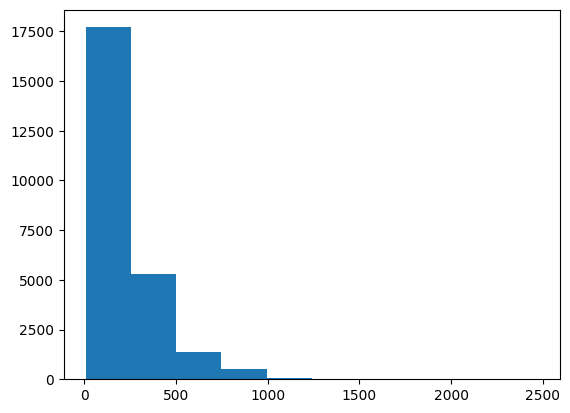

In [8]:
sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized,
                              sequence_length=sequence_length)
plt.hist(reviews_len);

In [9]:
train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

In [10]:
# Dataset and Dataloader
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device),
                              torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device),
                                   torch.from_numpy(validation_y).to(device))
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [11]:
# get a batch of data
train_data_iter = iter(train_dataloader)
X_example, y_example = next(train_data_iter)
print(f"Example Input size: {X_example.size()}")
print(f"Example Input:\n {X_example}")
print()
print(f"Example Output size: {y_example.size()}")
print(f"Example Output:\n {y_example}")

Example Input size: torch.Size([32, 512])
Example Input:
 tensor([[   10,  2642,    71,  ...,     1,    61,    41],
        [    0,     0,     0,  ...,   591,     4,   467],
        [    0,     0,     0,  ...,     5,    10,    17],
        ...,
        [    0,     0,     0,  ...,     4, 11166,   118],
        [    0,     0,     0,  ...,    31,    17,  1766],
        [    0,     0,     0,  ...,    14,    33,   511]])

Example Output size: torch.Size([32])
Example Output:
 tensor([1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0.])


In [12]:
# Define the model
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, 
                 hidden_dimension, output_dimension):
        super().__init__()
        self.embeddinglayer = nn.Embedding(input_dimension, embedding_dimension)
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
    def forward(self, sequence):
        embedding = self.embeddinglayer(sequence)
        output, hidden_state = self.rnn_layer(embedding)
        final_output = self.fc_layer(
            hidden_state[-1,:,:].squeeze(0))
        return final_output

In [13]:
input_dimension = len(vocab_to_token)+1
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1
rnn_model = RNN(input_dimension, embedding_dimension,
                hidden_dimension, output_dimension)
optim = optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()
rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [14]:
def accuracy_metric(predictions, ground_truth):
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float()
    accuracy = success.sum() / len(success)
    return accuracy

In [15]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    for sequence, sentiment in dataloader:
        optim.zero_grad()
        preds = model(sequence.T).squeeze()
        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_metric(preds, sentiment)
        loss_curr.backward()
        optim.step()
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
    return loss/len(dataloader), accuracy/len(dataloader)

In [16]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            preds = model(sequence.T).squeeze()
            loss_curr = loss_func(preds, sentiment)
            accuracy_curr = accuracy_metric(preds, sentiment)
            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
    return loss/len(dataloader), accuracy/len(dataloader)

In [17]:
num_epochs = 10
best_validation_loss = float('inf')
for ep in range(num_epochs):
    time_start = time.time()
    training_loss, train_accuracy = train(rnn_model, 
                                          train_dataloader,
                                         optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model,
                                                   validation_dataloader,
                                                   loss_func)
    time_end = time.time()
    time_delta = time_end - time_start
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} | validation accuracy: {validation_accuracy*100:.2f}%')

epoch number: 1 | time elapsed: 19.28411316871643s
training loss: 0.622 | training accuracy: 66.83%
validation loss: 0.960 | validation accuracy: 29.78%
epoch number: 2 | time elapsed: 19.10397982597351s
training loss: 0.593 | training accuracy: 68.82%
validation loss: 1.200 | validation accuracy: 22.58%
epoch number: 3 | time elapsed: 18.84195566177368s
training loss: 0.530 | training accuracy: 73.96%
validation loss: 0.933 | validation accuracy: 45.59%
epoch number: 4 | time elapsed: 18.83017873764038s
training loss: 0.442 | training accuracy: 79.93%
validation loss: 0.948 | validation accuracy: 52.62%
epoch number: 5 | time elapsed: 18.940852880477905s
training loss: 0.360 | training accuracy: 84.71%
validation loss: 0.951 | validation accuracy: 58.42%
epoch number: 6 | time elapsed: 18.95192790031433s
training loss: 0.337 | training accuracy: 85.97%
validation loss: 0.787 | validation accuracy: 65.64%
epoch number: 7 | time elapsed: 18.920658349990845s
training loss: 0.266 | traini

In [41]:
# real time inference
def sentiment_inference(model, sentence):
    model.eval()
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), mode='constant')
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    # Feed to model for predicition (Sigmoid because of Binary Classification)
    pred = torch.sigmoid(model(model_input))
    return pred.item()

print(sentiment_inference(rnn_model, "This film is horrible"))
print()
print(sentiment_inference(rnn_model, "Director tried really hard but the film wasn't good"))
print()
print(sentiment_inference(rnn_model, "The film was great. Loved it!"))

0.015297207981348038

0.29891225695610046

0.9813344478607178
